In [1]:
import json
import gzip
import math
from collections import defaultdict
import numpy as np
from sklearn import linear_model
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from scipy.sparse import hstack
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statistics
from collections import defaultdict
import collections
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def parse_csv_with_validation(file_path, expected_columns=13):
    valid_rows = []
    with gzip.open(file_path, mode='rt') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) == expected_columns:
                valid_rows.append(row)
    return valid_rows

data = parse_csv_with_validation("redditSubmissions.csv.gz")
df = pd.DataFrame(data[1:], columns=data[0])

In [3]:
df.head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
0,0,1333172439,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470,rmqjs,32657,funny,30813,1333197639,1844,622,Animates_Everything
1,0,1333178161,2012-03-31T14:16:01.093638-07:00,Expectation,35,rmun4,29,GifSound,6,1333203361,23,3,Gangsta_Raper
2,0,1333199913,2012-03-31T20:18:33.192906-07:00,Downvote,41,rna86,32,GifSound,9,1333225113,23,0,Gangsta_Raper
3,0,1333252330,2012-04-01T10:52:10-07:00,Every time I downvote something,10,ro7e4,6,GifSound,4,1333277530,2,0,Gangsta_Raper
4,0,1333272954,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65,rooof,57,GifSound,8,1333298154,49,0,Gangsta_Raper


In [4]:
df.shape

(132302, 13)

In [5]:
df.isnull().sum()

#image_id              0
unixtime               0
rawtime                0
title                  0
total_votes            0
reddit_id              0
number_of_upvotes      0
subreddit              0
number_of_downvotes    0
localtime              0
score                  0
number_of_comments     0
username               0
dtype: int64

In [6]:
#description of columns in df
print(df.describe())

       #image_id    unixtime                    rawtime              title  \
count     132302      132302                     132302             132302   
unique     16736      131854                     131949             122641   
top         6037  1345728457  2012-10-23T14:07:15+00:00  Haters gonna hate   
freq         166           2                          2                 49   

       total_votes reddit_id number_of_upvotes subreddit number_of_downvotes  \
count       132302    132302            132302    132302              132302   
unique       14766    132209             11050       867                9853   
top             10    1103nc                 4     funny                   4   
freq          3038         2              5098     55277                6246   

         localtime   score number_of_comments username  
count       132302  132302             132302   132302  
unique      131870    2863               1345    63334  
top     1348682619       1           

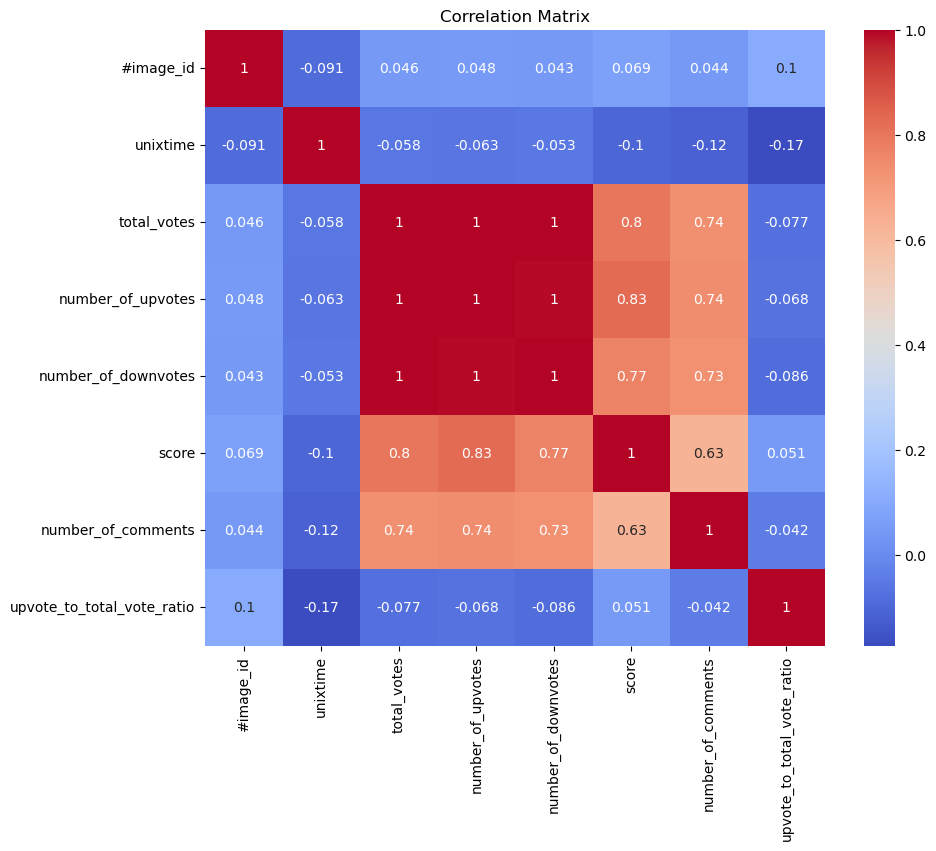

In [7]:
#plotting correlations across numerical columns
numerical_df = df[['#image_id', 'unixtime', 'total_votes', 'number_of_upvotes', 'number_of_downvotes', 'score', 'number_of_comments']]
for i in numerical_df.columns:
    numerical_df[i] = numerical_df[i].astype(int)
    df[i] = df[i].astype(int)
df['upvote_to_total_vote_ratio'] = df['number_of_upvotes']/(df['total_votes'] + 1)
numerical_df['upvote_to_total_vote_ratio'] = numerical_df['number_of_upvotes']/(df['total_votes'] + 1)
correlation_matrix = numerical_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
print(f"Average number of upvotes: {df['number_of_upvotes'].mean()}")

Average number of upvotes: 1058.182899729407


In [9]:
print(f"Average upvote to total vote ratio: {(df['number_of_upvotes']/df['total_votes']).mean()}")

Average upvote to total vote ratio: 0.6270574128424524


### User Specific Analysis

In [10]:
#average upvotes per user
average_upvotes_per_user = df.groupby('username')['number_of_upvotes'].mean().sort_values(ascending=False)
average_upvotes_per_user

username
lepry             90396.0
Robert_Houdin     67767.0
RuffDesperado     64987.0
frackyou          63392.0
dwerb99           62048.0
                   ...   
SpeedracerMeow        0.0
electrilizer          0.0
RAPTURE2              0.0
FoxxyFrost            0.0
kohkahkohla           0.0
Name: number_of_upvotes, Length: 63334, dtype: float64

In [11]:
#average upvote/total_vote ratio per user
average_upvote_to_total_vote_per_user = df.groupby('username')['upvote_to_total_vote_ratio'].mean().sort_values(ascending=False)
average_upvote_to_total_vote_per_user

username
dangerousD85           0.980000
ceqarht                0.977099
Youtube-Top-Comment    0.974359
awesomesauce1243       0.973684
vagueabond             0.972222
                         ...   
IPickOnYou             0.000000
sharpee05              0.000000
FoxxyFrost             0.000000
Rovner                 0.000000
modestmewtwo           0.000000
Name: upvote_to_total_vote_ratio, Length: 63334, dtype: float64

### Post Level Analysis

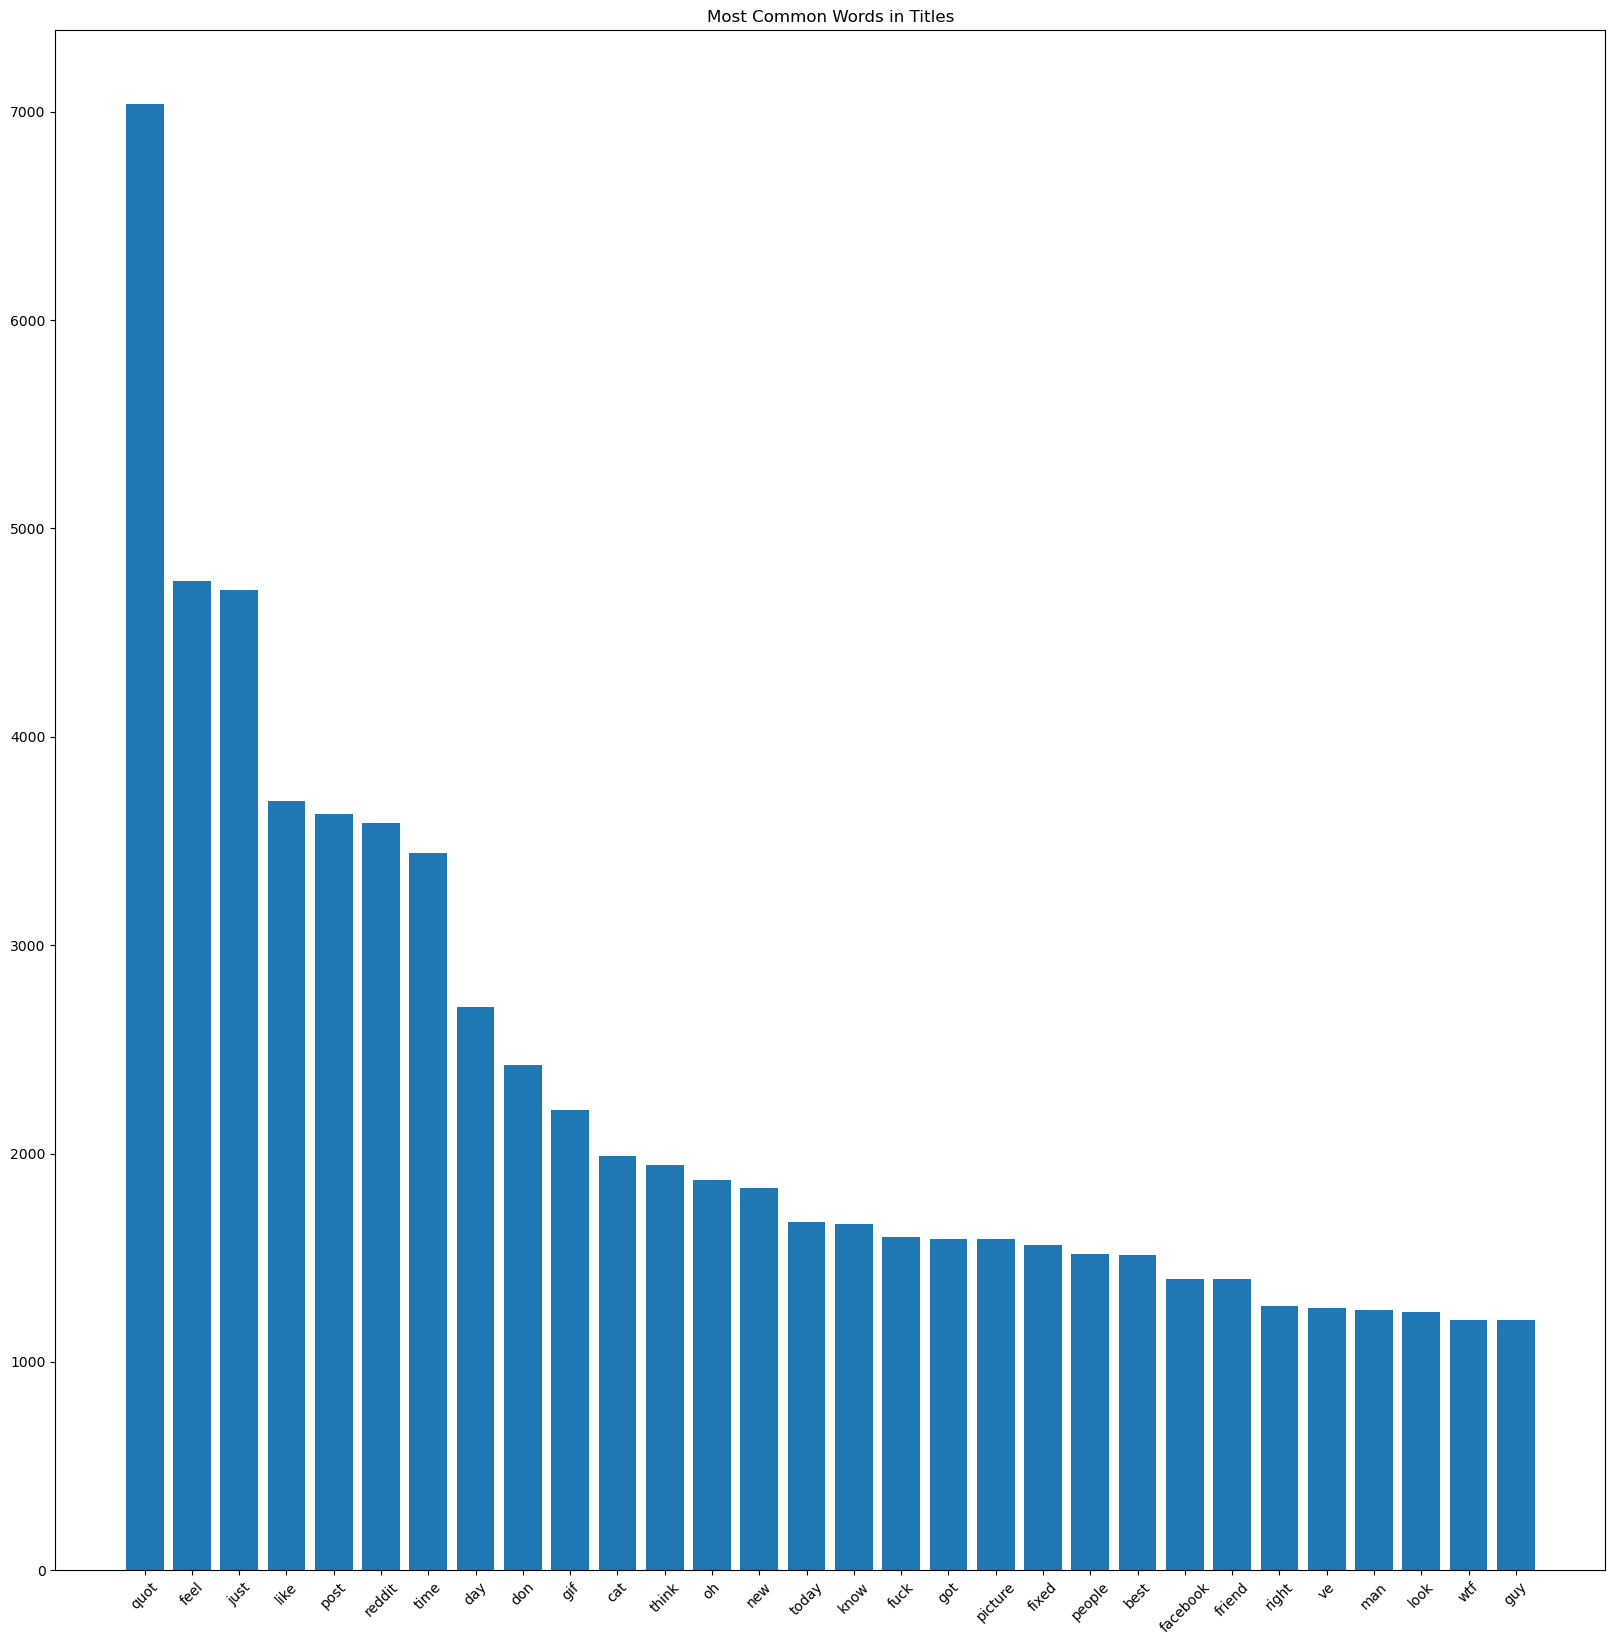

In [12]:
vectorizer = CountVectorizer(stop_words='english')
title_matrix = vectorizer.fit_transform(df['title']) 
word_counts = np.array(title_matrix.sum(axis=0)).flatten() #get word counts
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts)) # Map words to their frequencies
common_words = Counter(word_freq).most_common(10) # get top k most common words (in this case, 10)
common_words = Counter(word_freq).most_common(30)
words, frequencies = zip(*common_words)
plt.figure(figsize=(20, 20))
plt.bar(words, frequencies)
plt.xticks(rotation=45)
plt.title('Most Common Words in Titles')

plt.show()

In [13]:
# Gets word related to largest ratio upvotes
word_counts = title_matrix.sum(axis=0)
words = vectorizer.get_feature_names_out()
upvotes = title_matrix.T @ df['upvote_to_total_vote_ratio'].values
word_data = pd.DataFrame({'word': words, 'frequency': word_counts.A1, 'ratio': upvotes})
word_data['avg_upvotes'] = word_data['ratio'] / word_data['frequency']
top_words = word_data.sort_values(by=['avg_upvotes', 'frequency'], ascending=False)
top_words = top_words[top_words['frequency'] > 20].head(20)
top_words

,word,frequency,ratio,avg_upvotes
12647,hifw,115,92.455205,0.803958
309,1920x1080,32,25.105888,0.784559
24507,solar,25,18.945017,0.757801
11213,geographic,23,17.244238,0.749749
4557,california,36,26.989782,0.749716
27443,twain,22,16.427898,0.746723
24106,skyline,33,24.385749,0.738962
2142,armadillo,21,15.449018,0.735668
5649,climbing,24,17.595612,0.733151
20279,pope,23,16.773375,0.729277


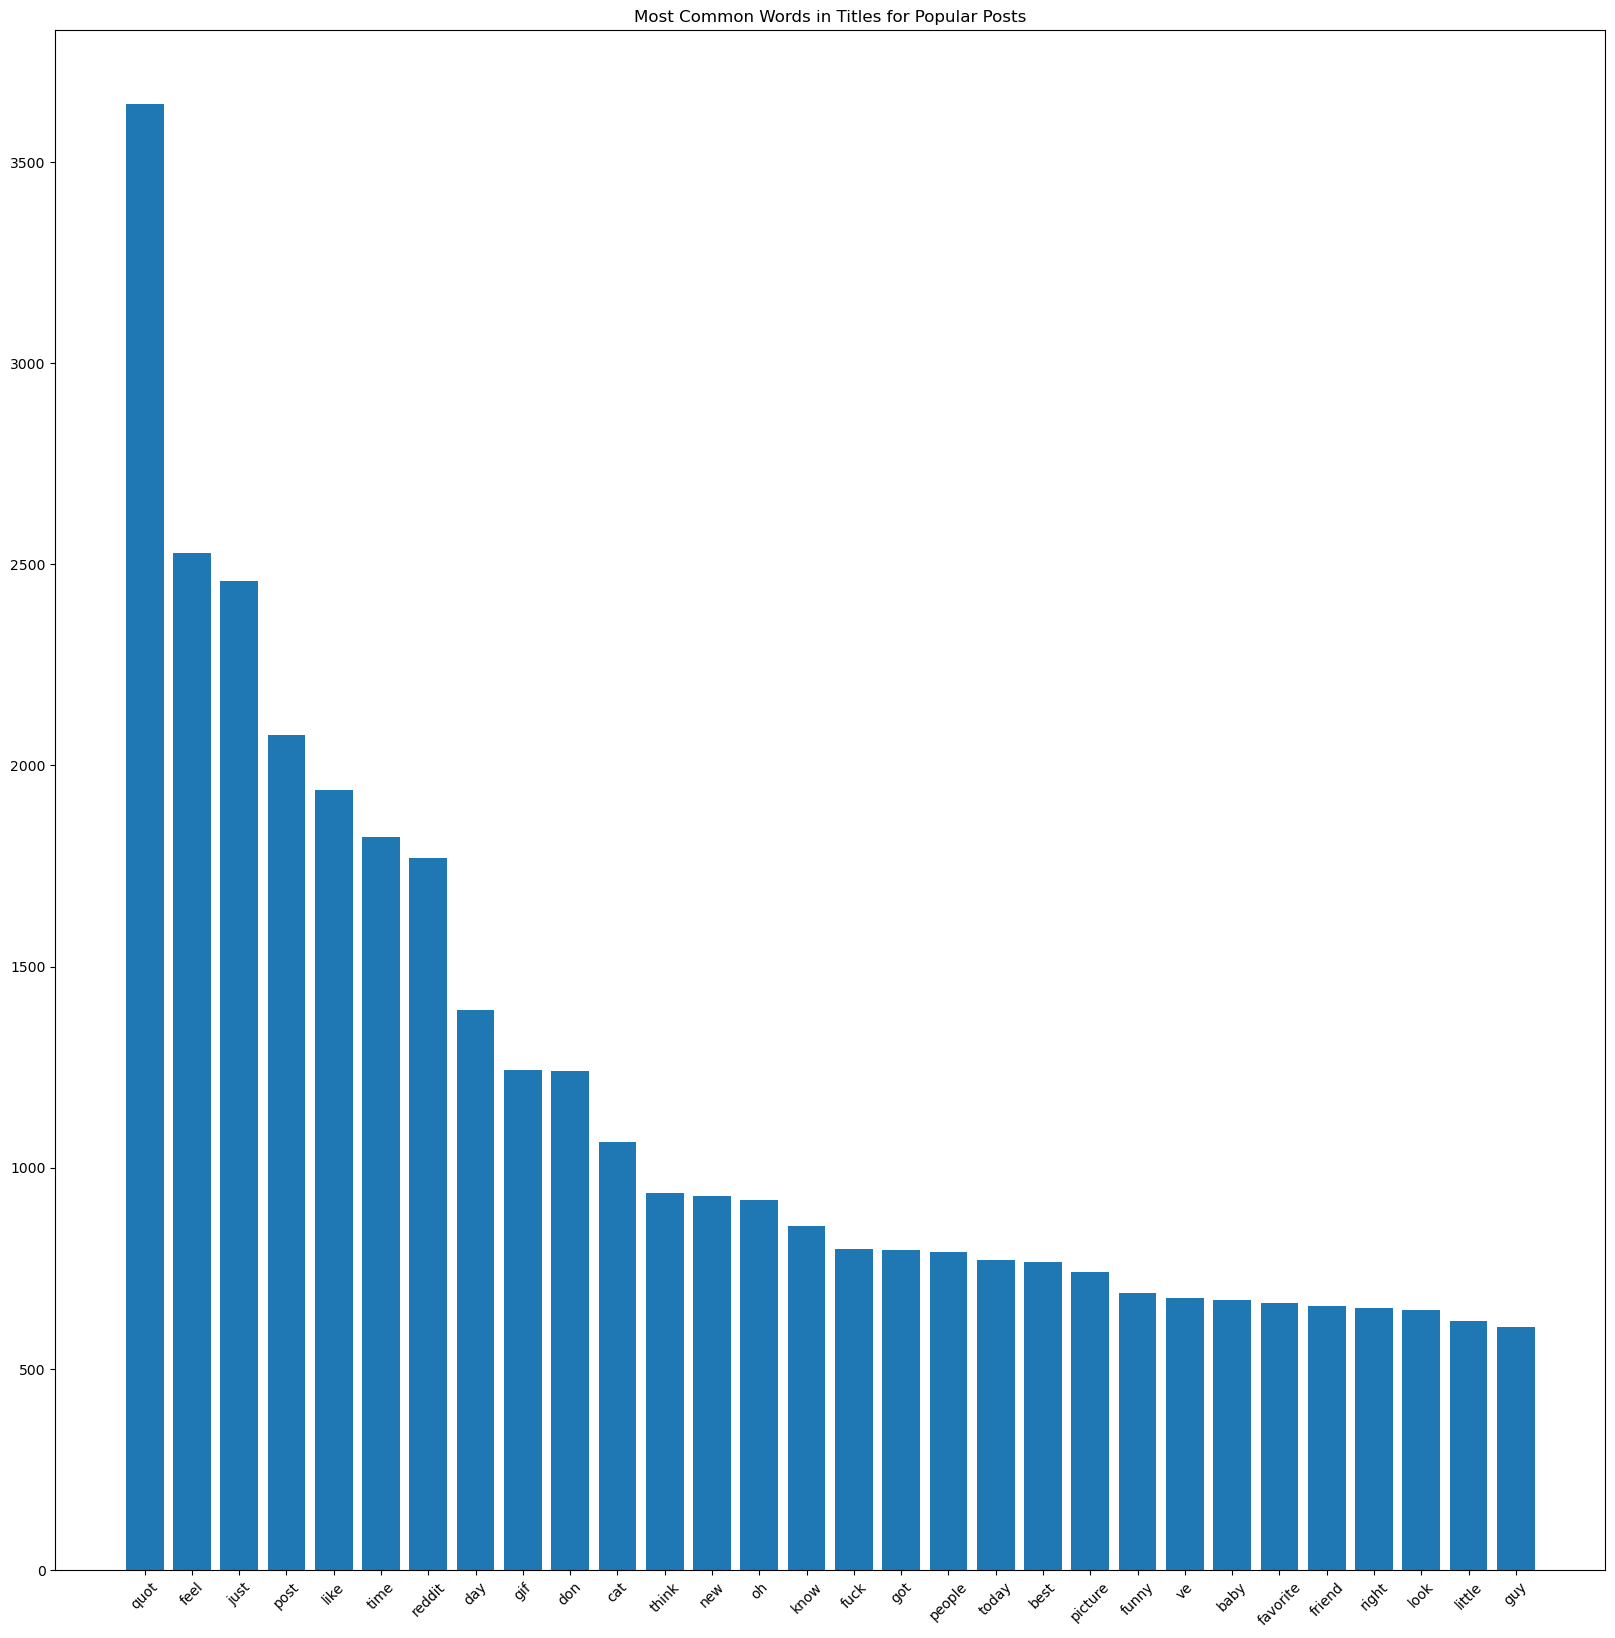

In [14]:
# checking word count based on posts with larger upvote ratios (ie more upvotes to downvotes)

popular_posts = df[df['upvote_to_total_vote_ratio'] > df['upvote_to_total_vote_ratio'].mean()]
vectorizer = CountVectorizer(stop_words='english')
title_matrix = vectorizer.fit_transform(popular_posts['title'])
word_counts = np.array(title_matrix.sum(axis=0)).flatten() #get word counts
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts)) # Map words to their frequencies
common_words = Counter(word_freq).most_common(10) # get top k most common words (in this case, 10)
common_words = Counter(word_freq).most_common(30)  #some words change frequency as expected and there are some constant (quot for example) but there does seem to be change
words, frequencies = zip(*common_words)
plt.figure(figsize=(20, 20))
plt.bar(words, frequencies)
plt.xticks(rotation=45)
plt.title('Most Common Words in Titles for Popular Posts')

plt.show()

In [15]:
word_counts = title_matrix.sum(axis=0)  # based on popular posts, words seem to change
words = vectorizer.get_feature_names_out()
upvotes = title_matrix.T @ popular_posts['upvote_to_total_vote_ratio'].values
word_data = pd.DataFrame({'word': words, 'frequency': word_counts.A1, 'total_upvotes': upvotes})
word_data['avg_upvotes'] = word_data['total_upvotes'] / word_data['frequency']
top_words = word_data.sort_values(by=['avg_upvotes', 'frequency'], ascending=False)
top_words = top_words[top_words['frequency'] > 20].head(20)
top_words

,word,frequency,total_upvotes,avg_upvotes
9704,hifw,106,88.303603,0.833053
6948,enemy,23,18.846506,0.819413
10074,hugs,21,16.796535,0.799835
18777,solar,22,17.567099,0.798504
16447,reactiongifs,21,16.678017,0.794191
12454,manhattan,29,23.016800,0.793683
13002,milky,36,28.550201,0.793061
3490,california,31,24.515365,0.790818
263,1920x1080,31,24.505888,0.790513
13592,nap,29,22.902566,0.789744


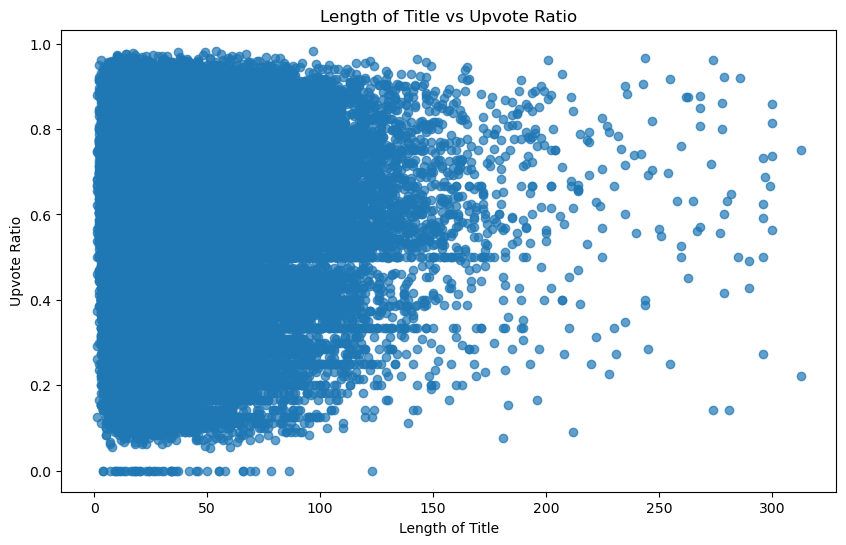

In [16]:
# Scatter of Title lengths and upvote counts
df['length of title'] = df['title'].str.len()
plt.figure(figsize=(10, 6))
plt.scatter(df['length of title'], df['upvote_to_total_vote_ratio'], alpha=0.7)
plt.title('Length of Title vs Upvote Ratio')
plt.xlabel('Length of Title')
plt.ylabel('Upvote Ratio')
plt.show()

<Axes: xlabel='hour', ylabel='Median Total Votes'>

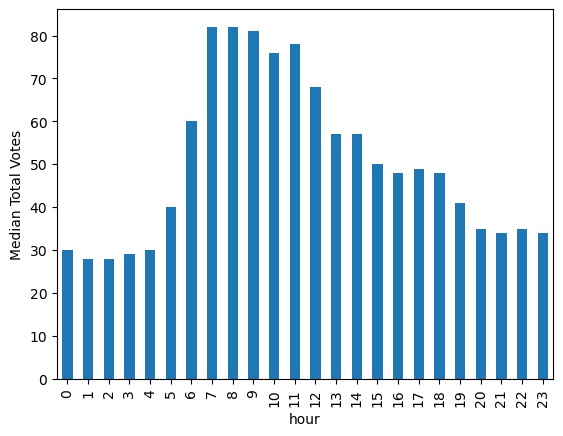

In [17]:
df['hour'] = pd.to_datetime(df['localtime'], unit='s').dt.hour
total_votes_df = df.groupby('hour')['total_votes'].median()
total_votes_df.plot(kind='bar', ylabel='Median Total Votes')

<Axes: xlabel='hour', ylabel='Median Total Votes'>

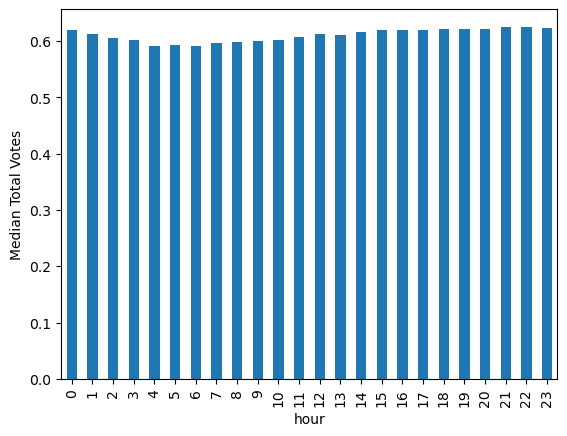

In [18]:
upvote_ratio_df = df.groupby('hour')['upvote_to_total_vote_ratio'].median()
upvote_ratio_df.plot(kind='bar', ylabel='Median Total Votes')

In [19]:
np.floor(df['hour']/4).corr(df['upvote_to_total_vote_ratio'])

0.03356534396372175

<Axes: xlabel='month', ylabel='Average Upvote Ratio per Month'>

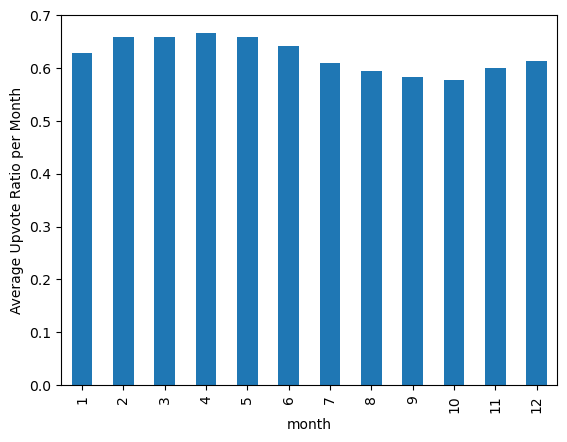

In [20]:
# Average post upvotes over months
df['month'] = pd.to_datetime(df['localtime'], unit='s').dt.month
upvote_score = df.groupby('month')['upvote_to_total_vote_ratio'].median() #using median since the data pretty easily has outliers
upvote_score.plot(kind='bar', ylabel="Average Upvote Ratio per Month")

array([[<Axes: title={'center': 'number_of_upvotes'}>,
        <Axes: title={'center': 'upvote_to_total_vote_ratio'}>]],
      dtype=object)

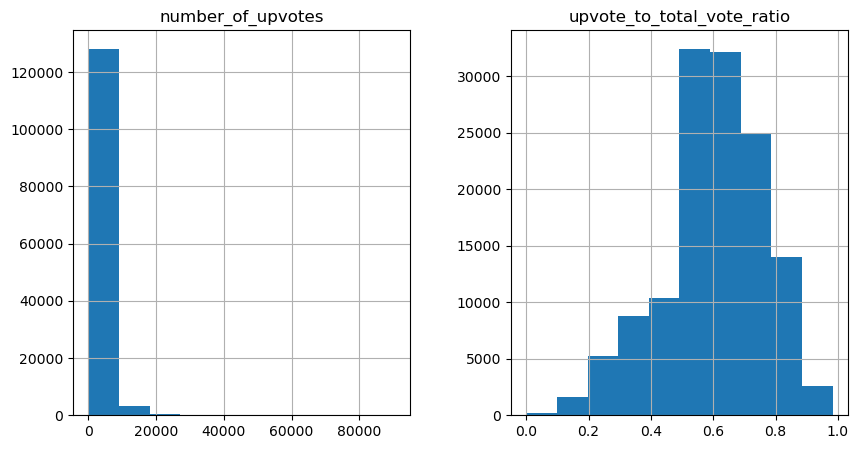

In [21]:
#histogram of upvotes, score and number of comments
df[['number_of_upvotes', 'upvote_to_total_vote_ratio']].hist(figsize=(10, 5))

## Subreddit Analysis

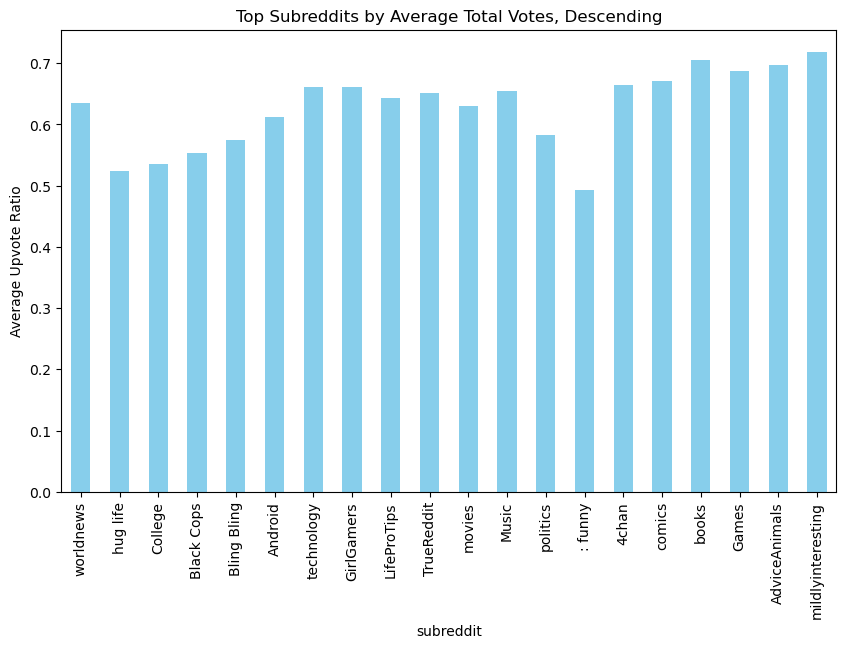

In [22]:
activity = df.groupby('subreddit').agg(  
    avg_votes=('total_votes', 'mean'),   
    avg_upvotes=('number_of_upvotes', 'mean'),
    avg_upvote_ratio=('upvote_to_total_vote_ratio', 'mean'),
    avg_comments=('number_of_comments', 'mean')
).sort_values(['avg_votes', 'avg_upvote_ratio'], ascending=False)
top = activity.head(20)
top['avg_upvote_ratio'].plot(kind='bar', figsize=(10, 6), color='skyblue', title='Top Subreddits by Average Total Votes, Descending')
plt.ylabel('Average Upvote Ratio')
plt.show()

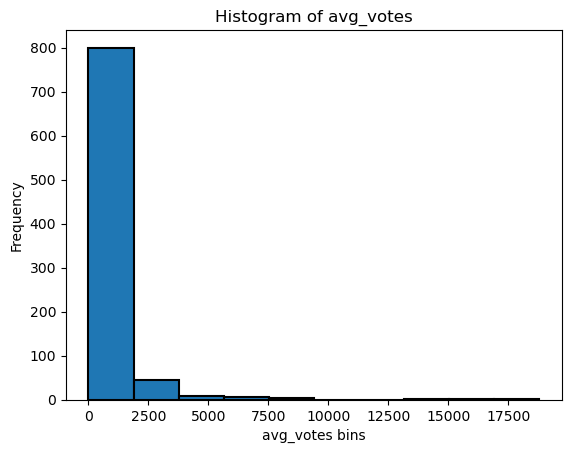

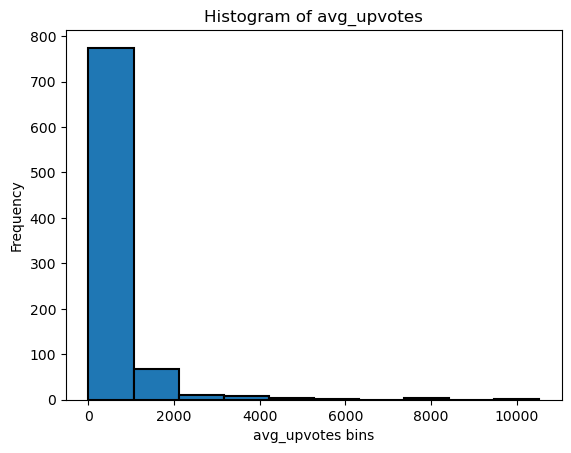

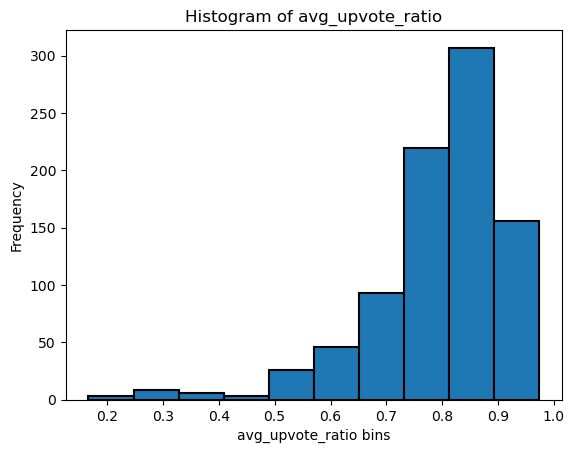

In [23]:
#fig = plt.figure(figsize = (15,20))
#ax = fig.gca()
#activity[['avg_votes', 'avg_upvotes', 'avg_upvote_ratio']].hist(ax = ax, edgecolor='black', linewidth=1.5, grid=False)
plt.xlabel("Bins")
plt.ylabel("Frequency")
for col in activity[['avg_votes', 'avg_upvotes', 'avg_upvote_ratio']].columns:
    #activity[['avg_votes', 'avg_upvotes', 'avg_upvote_ratio']][col].hist(ax = ax, edgecolor='black', linewidth=1.5, grid=False)
    activity[['avg_votes', 'avg_upvotes', 'avg_upvote_ratio']][col].hist(edgecolor='black', linewidth=1.5, grid=False)
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col} bins')
    plt.ylabel('Frequency')
    plt.show()

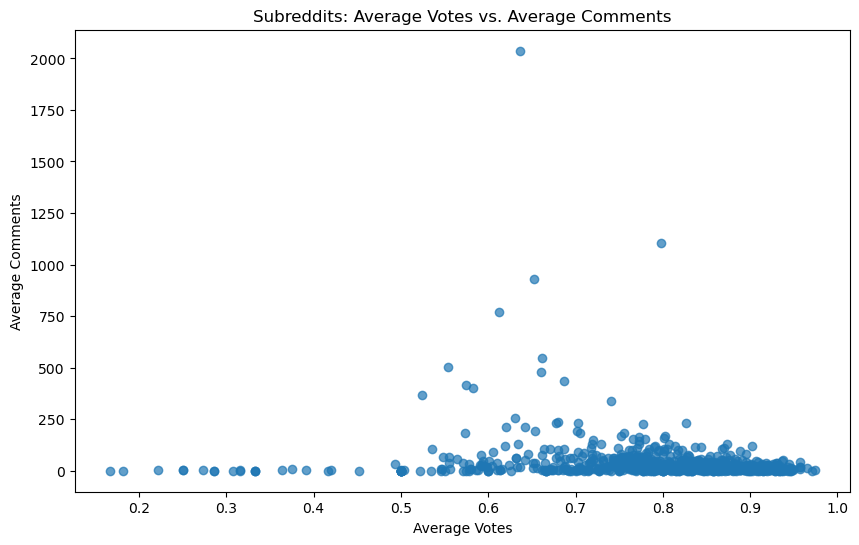

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(activity['avg_upvote_ratio'], activity['avg_comments'], alpha=0.7)
plt.title('Subreddits: Average Votes vs. Average Comments')
plt.xlabel('Average Votes')
plt.ylabel('Average Comments')
plt.show()

In [25]:
# Analyzing word frequency per subreddit in title, example here uses 'aww'

popular_subreddit = df[df['subreddit'] == 'aww']
vectorizer = CountVectorizer(stop_words='english')
title_matrix = vectorizer.fit_transform(popular_subreddit['title'])
word_counts = np.array(title_matrix.sum(axis=0)).flatten() #get word counts
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts)) # Map words to their frequencies
common_words = Counter(word_freq).most_common(10) # get top k most common words (in this case, 10)
print(common_words)

[('baby', 485), ('just', 389), ('cat', 306), ('cute', 301), ('little', 233), ('quot', 213), ('dog', 187), ('kitty', 159), ('aww', 150), ('post', 136)]


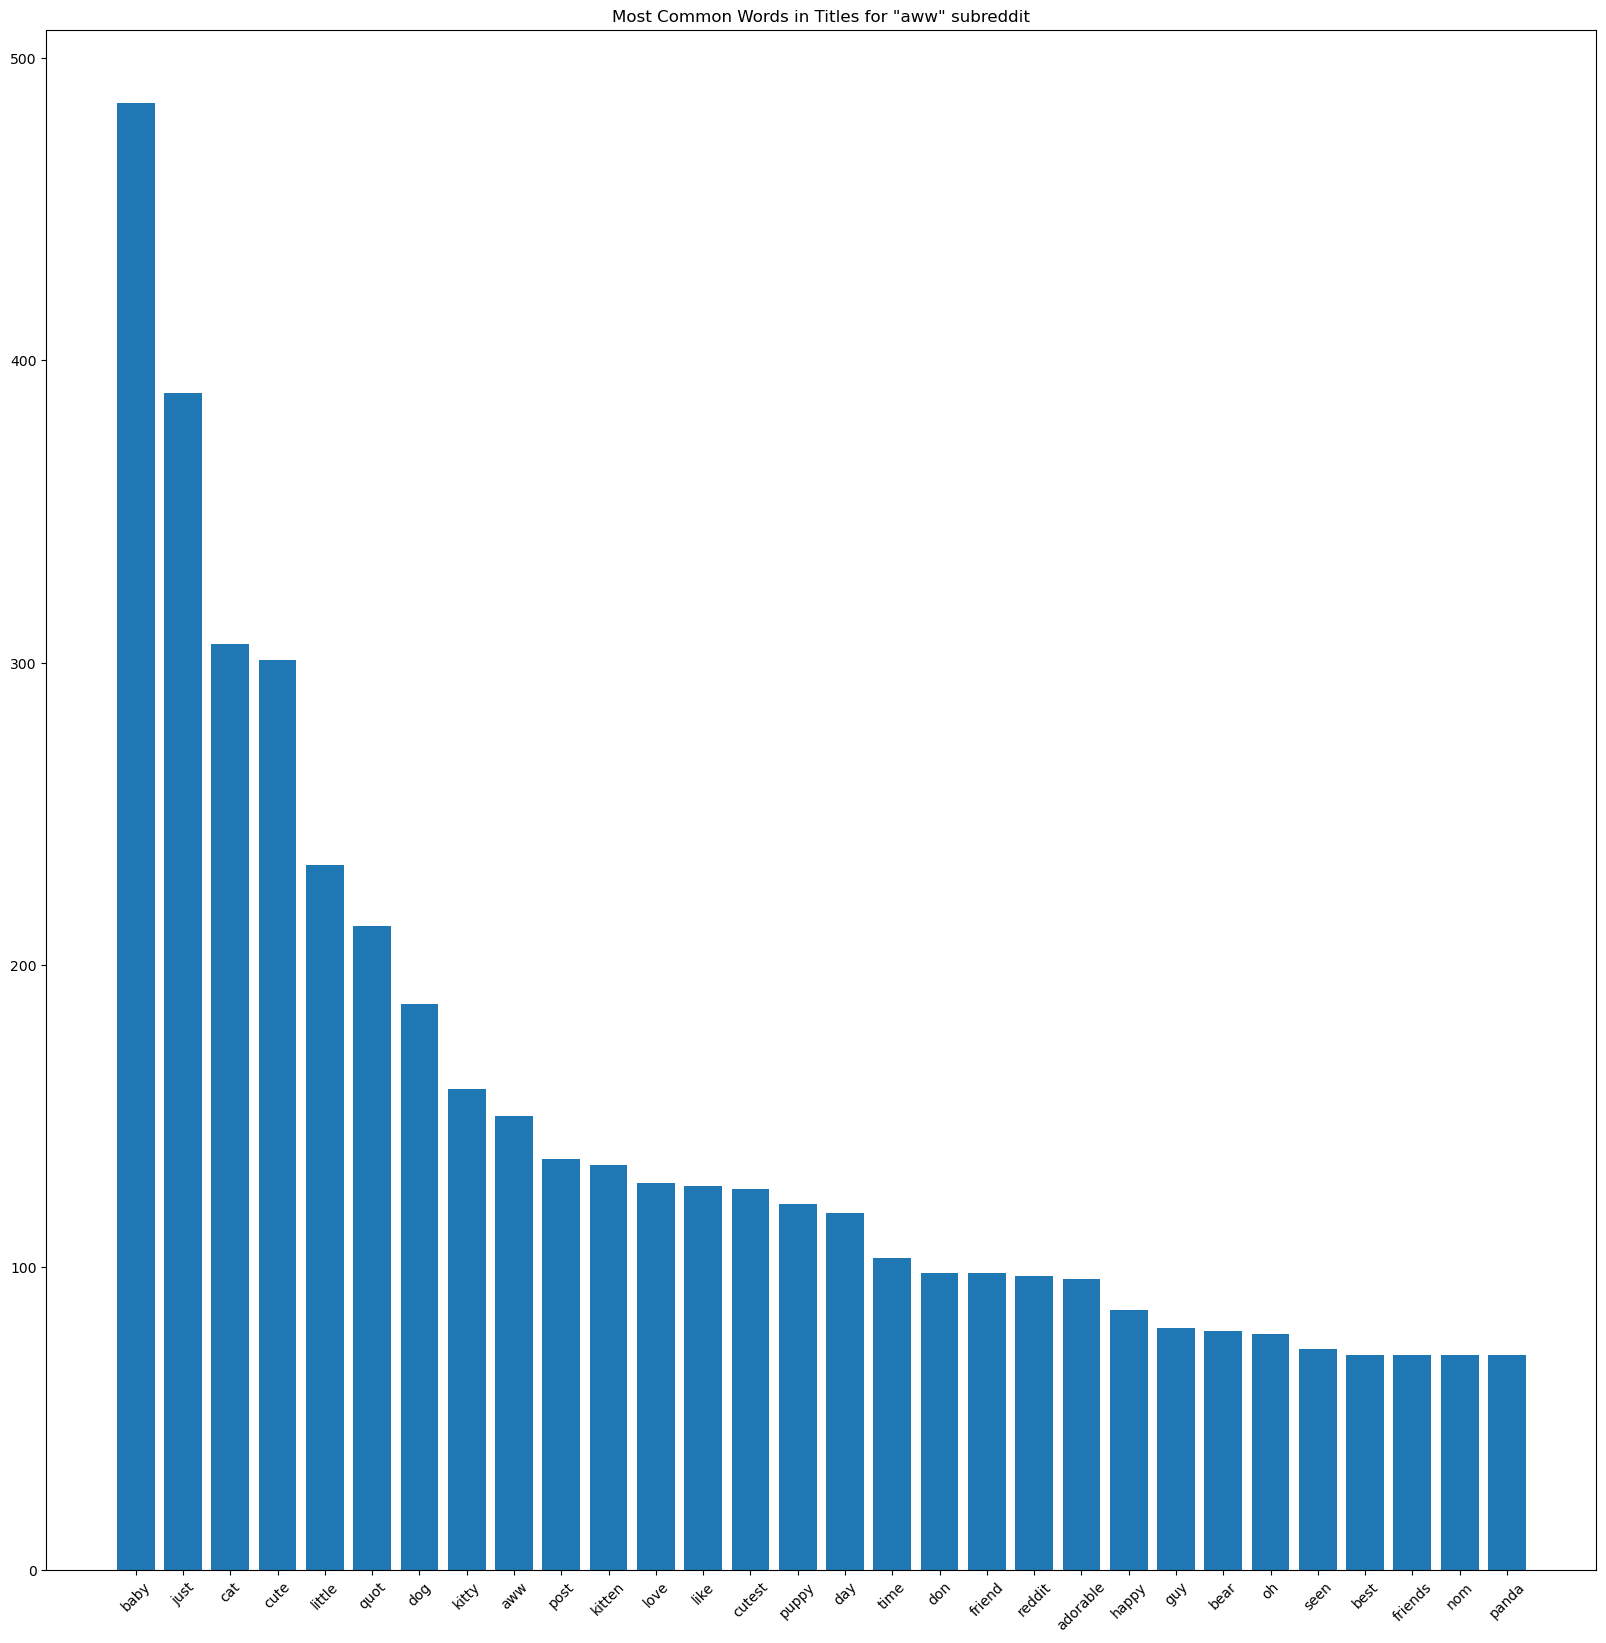

In [26]:
common_words = Counter(word_freq).most_common(30)  #some words change frequency as expected and there are some constant (quot for example) but there does seem to be change
words, frequencies = zip(*common_words)
plt.figure(figsize=(20, 20))
plt.bar(words, frequencies)
plt.xticks(rotation=45)
plt.title('Most Common Words in Titles for "aww" subreddit')

plt.show()

In [27]:
word_counts = title_matrix.sum(axis=0)  # based on popular posts, words seem to change
words = vectorizer.get_feature_names_out()
upvotes = title_matrix.T @ popular_subreddit['upvote_to_total_vote_ratio'].values
word_data = pd.DataFrame({'word': words, 'frequency': word_counts.A1, 'upvote_to_total_vote_ratio': upvotes})
word_data['avg_upvote_ratios'] = word_data['upvote_to_total_vote_ratio'] / word_data['frequency']
top_words = word_data.sort_values(by=['avg_upvote_ratios', 'frequency'], ascending=False)
top_words[top_words['frequency'] > 20].head(20)

,word,frequency,upvote_to_total_vote_ratio,avg_upvote_ratios
2337,needs,28,21.994716,0.785526
2891,red,48,37.323314,0.777569
849,cup,31,24.056048,0.776002
3193,sloth,36,27.885789,0.774605
1933,koala,30,22.991668,0.766389
3770,want,56,42.398631,0.757118
2117,makes,26,19.660526,0.756174
1305,fish,21,15.796222,0.752201
2507,panda,71,53.232907,0.749759
2851,raise,23,17.218232,0.748619


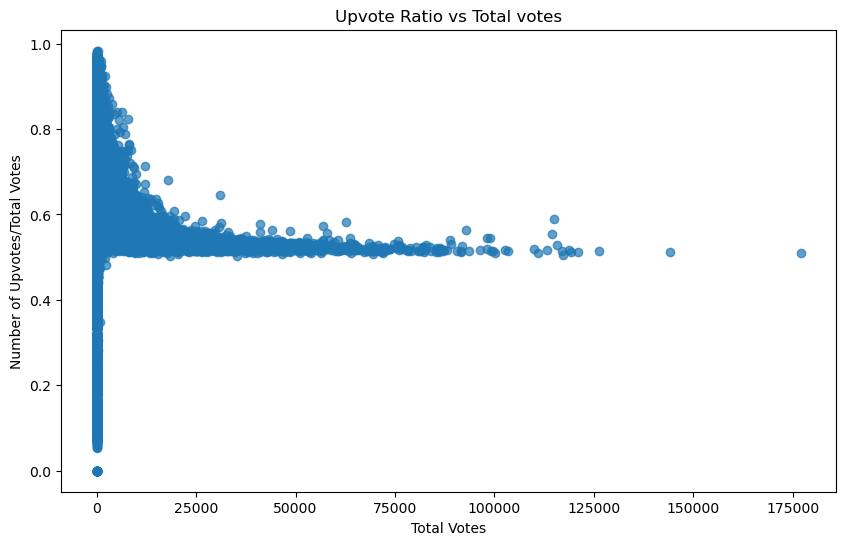

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(df['total_votes'], df['number_of_upvotes']/(df['total_votes'] + 1), alpha=0.7)
plt.title('Upvote Ratio vs Total votes')
plt.xlabel('Total Votes')
plt.ylabel('Number of Upvotes/Total Votes')
plt.show()

In [29]:
dict_total_votes_to_ratio = defaultdict(set)
for _, d in df[['total_votes', 'upvote_to_total_vote_ratio']].iterrows():
    dict_total_votes_to_ratio[d['total_votes']].add(d['upvote_to_total_vote_ratio'])

In [30]:
total_vote_ratio_averages = {}
for i in dict_total_votes_to_ratio:
    total_vote_ratio_averages[i] = sum(dict_total_votes_to_ratio[i])/len(dict_total_votes_to_ratio[i])

od = collections.OrderedDict(sorted(total_vote_ratio_averages.items()))

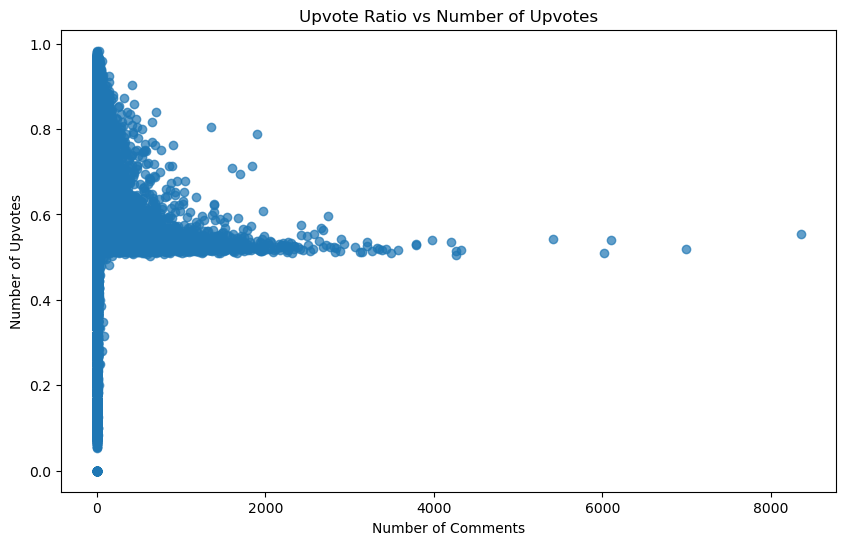

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df['number_of_comments'], df['number_of_upvotes']/(df['total_votes'] + 1), alpha=0.7)
plt.title('Upvote Ratio vs Number of Upvotes')
plt.xlabel('Number of Comments')
plt.ylabel('Number of Upvotes')
plt.show()

In [32]:
df['rawtime_datetime'] = pd.to_datetime(df['rawtime'], format='ISO8601', errors='coerce')

In [33]:
testing = df['rawtime'].str.replace(r'([-+]\d{2}):(\d{2})$', r'\1\2', regex=True)
pd.to_datetime(testing, errors='coerce', utc=True)

0        2012-03-31 19:40:39.590113+00:00
1        2012-03-31 21:16:01.093638+00:00
2        2012-04-01 03:18:33.192906+00:00
3                                     NaT
4        2012-04-01 23:35:54.393381+00:00
                       ...               
132297                                NaT
132298                                NaT
132299                                NaT
132300                                NaT
132301                                NaT
Name: rawtime, Length: 132302, dtype: datetime64[ns, UTC]

In [34]:
def func(x):
    if len(x) > 3 and len(x[2]) < len('31T12:40:39.590113'):
        x[2] = x[2] + ".000000"
        return x
    return x

def combine(x):
    string = ""
    for i in x:
        if len(string) == 0:
            string = i
        else:
            string = string + "-" + i
    return string
def func2(x):
    if len(x) > 1 and len(x[0]) < len('2012-08-18T13:09:38.000000'):
        x[0] = x[0] + ".000000"
        return x
    return x
def combine2(x):
    string = ""
    for i in x:
        if len(string) == 0:
            string = i
        else:
            string = string + "+" + i
    return string

testing = df['rawtime'].str.split("-").apply(func).apply(combine).str.split("+").apply(func2).apply(combine2)
testing

0         2012-03-31T12:40:39.590113-07:00
1         2012-03-31T14:16:01.093638-07:00
2         2012-03-31T20:18:33.192906-07:00
3         2012-04-01T10:52:10.000000-07:00
4         2012-04-01T16:35:54.393381-07:00
                        ...               
132297    2012-08-12T15:24:06.000000-07:00
132298    2012-08-18T13:09:38.000000-07:00
132299    2012-08-26T04:06:02.000000+00:00
132300    2012-09-02T22:45:06.000000+00:00
132301    2012-09-15T14:00:43.000000+00:00
Name: rawtime, Length: 132302, dtype: object

In [35]:
df['parsed_time'] = pd.to_datetime(testing, utc=True)
df['parsed_time']

0        2012-03-31 19:40:39.590113+00:00
1        2012-03-31 21:16:01.093638+00:00
2        2012-04-01 03:18:33.192906+00:00
3               2012-04-01 17:52:10+00:00
4        2012-04-01 23:35:54.393381+00:00
                       ...               
132297          2012-08-12 22:24:06+00:00
132298          2012-08-18 20:09:38+00:00
132299          2012-08-26 04:06:02+00:00
132300          2012-09-02 22:45:06+00:00
132301          2012-09-15 14:00:43+00:00
Name: parsed_time, Length: 132302, dtype: datetime64[ns, UTC]

In [36]:
df['parsed_time'].dt.hour

0         19
1         21
2          3
3         17
4         23
          ..
132297    22
132298    20
132299     4
132300    22
132301    14
Name: parsed_time, Length: 132302, dtype: int32

In [37]:
df['hour']

0         12
1         14
2         20
3         10
4         16
          ..
132297    15
132298    13
132299     4
132300    22
132301    14
Name: hour, Length: 132302, dtype: int32

<Axes: xlabel='parsed_hour', ylabel='Median Total Votes'>

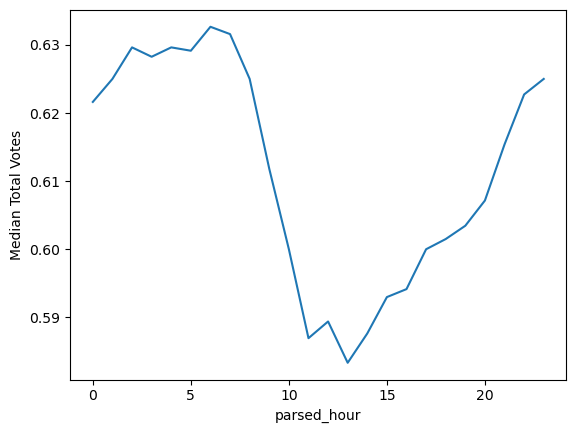

In [38]:
df['parsed_hour'] = df['parsed_time'].dt.hour
total_votes_df = df.groupby('parsed_hour')['upvote_to_total_vote_ratio'].median()
total_votes_df.plot(kind='line', ylabel='Median Total Votes')

<Axes: xlabel='parsed_month', ylabel='Median Total Votes'>

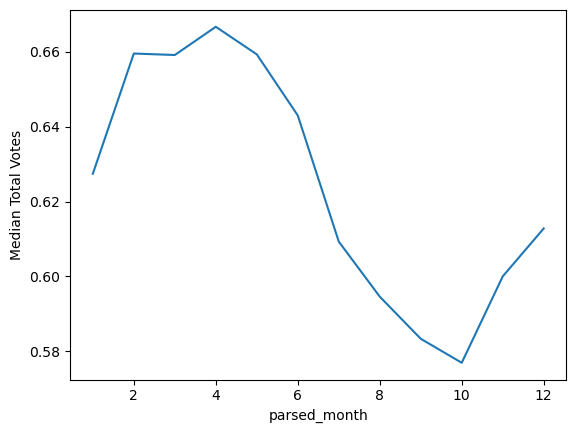

In [39]:
df['parsed_month'] = df['parsed_time'].dt.month
total_votes_df = df.groupby('parsed_month')['upvote_to_total_vote_ratio'].median()
total_votes_df.plot(kind='line', ylabel='Median Total Votes')

<Axes: xlabel='parsed_day', ylabel='Median Total Votes'>

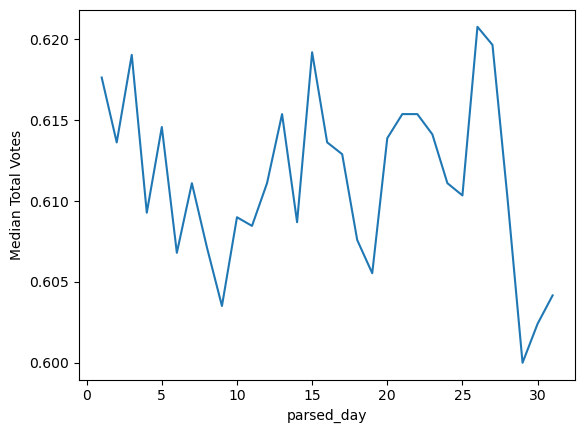

In [40]:
df['parsed_day'] = df['parsed_time'].dt.day
total_votes_df = df.groupby('parsed_day')['upvote_to_total_vote_ratio'].median()
total_votes_df.plot(kind='line', ylabel='Median Total Votes')

<Axes: xlabel='parsed_year', ylabel='Median Total Votes'>

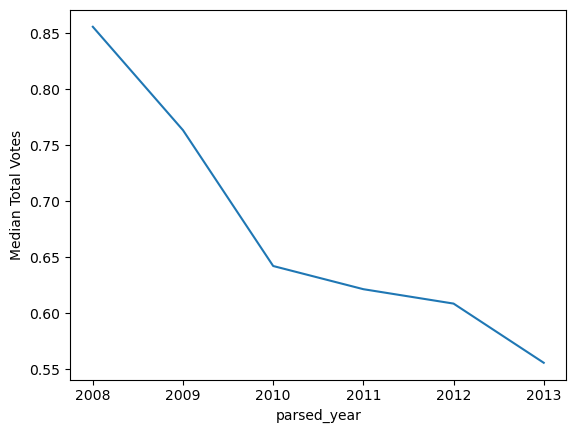

In [41]:
df['parsed_year'] = df['parsed_time'].dt.year
total_votes_df = df.groupby('parsed_year')['upvote_to_total_vote_ratio'].median()
total_votes_df.plot(kind='line', ylabel='Median Total Votes')

Text(0, 0.5, 'Upvote Ratio')

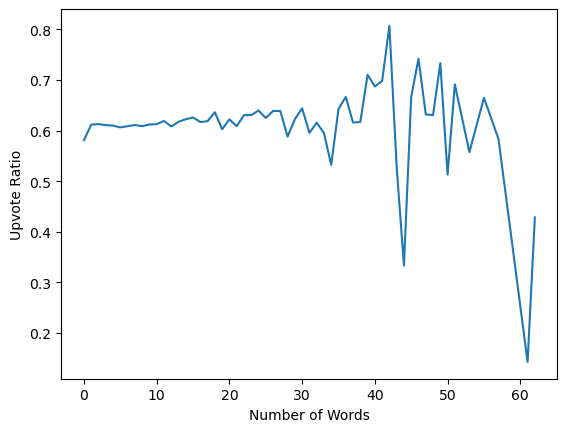

In [42]:
sp = set(string.punctuation)

def converter(x):
    t = [c for c in x if not (c in sp)]
    t = ''.join(t)
    words = t.strip().split()
    return words

df['num_words'] = df['title'].str.lower().apply(converter).str.len()
df['subreddit_len'] = df['subreddit'].str.len()
scaler = MinMaxScaler()
df['subreddit_len'] = df['subreddit_len'] / df['subreddit_len'].max()
num_df = df.groupby('num_words')['upvote_to_total_vote_ratio'].median().reset_index()
plt.plot(num_df['num_words'], num_df['upvote_to_total_vote_ratio'])
plt.xlabel('Number of Words')
plt.ylabel('Upvote Ratio')

In [43]:
df['subreddit_len'].min()

0.013157894736842105

In [44]:
df.groupby('parsed_hour')['upvote_to_total_vote_ratio'].median()

parsed_hour
0     0.621622
1     0.625000
2     0.629630
3     0.628251
4     0.629630
5     0.629138
6     0.632653
7     0.631579
8     0.625000
9     0.611809
10    0.600000
11    0.586943
12    0.589395
13    0.583333
14    0.587638
15    0.592977
16    0.594147
17    0.600000
18    0.601496
19    0.603448
20    0.607152
21    0.615385
22    0.622719
23    0.625000
Name: upvote_to_total_vote_ratio, dtype: float64

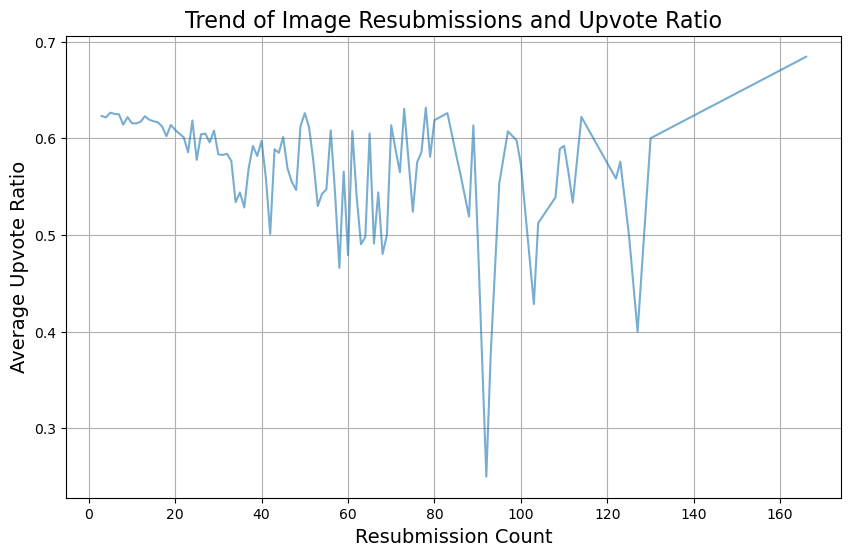

In [45]:
# Group by image_id
image_stats = df.groupby('#image_id').agg(
    resubmission_count=('#image_id', 'size'),  # Count the number of times each image is used
    average_upvote_ratio=('upvote_to_total_vote_ratio', 'median')  # Calculate the mean upvote ratio
).reset_index()

# Sort by resubmission count for better visualization
image_stats = image_stats.sort_values('resubmission_count', ascending=False)


resub_images = image_stats.groupby('resubmission_count')[['average_upvote_ratio']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=resub_images, x='resubmission_count', y='average_upvote_ratio', alpha=0.6)

# Add titles and labels
plt.title("Trend of Image Resubmissions and Upvote Ratio", fontsize=16)
plt.xlabel("Resubmission Count", fontsize=14)
plt.ylabel("Average Upvote Ratio", fontsize=14)
plt.grid(True)
plt.show()

In [46]:
df = df.merge(image_stats[['#image_id', 'resubmission_count']], on='#image_id', how='left')
df['resubmission_count'] = df['resubmission_count'].fillna(1)

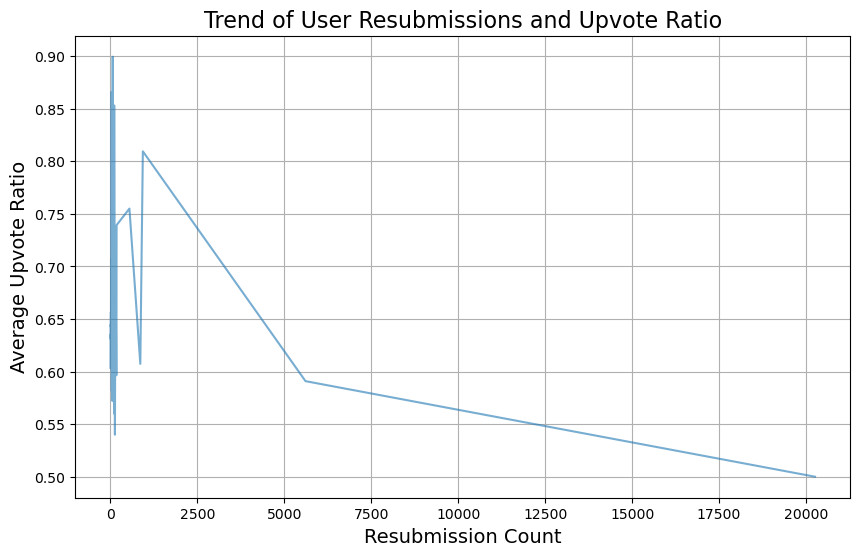

In [47]:
# Group by image_id
image_stats = df.groupby('username').agg(
    user_resubmission_count=('username', 'size'),  # Count the number of times each image is used
    average_upvote_ratio=('upvote_to_total_vote_ratio', 'median')  # Calculate the mean upvote ratio
).reset_index()

# Sort by resubmission count for better visualization
image_stats = image_stats.sort_values('user_resubmission_count', ascending=False)


resub_images = image_stats.groupby('user_resubmission_count')[['average_upvote_ratio']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=resub_images, x='user_resubmission_count', y='average_upvote_ratio', alpha=0.6)

# Add titles and labels
plt.title("Trend of User Resubmissions and Upvote Ratio", fontsize=16)
plt.xlabel("Resubmission Count", fontsize=14)
plt.ylabel("Average Upvote Ratio", fontsize=14)
plt.grid(True)
plt.show()

In [48]:
df = df.merge(image_stats[['username', 'user_resubmission_count']], on='username', how='left')
df['user_resubmission_count'] = df['user_resubmission_count'].fillna(1)

In [49]:
print(df['parsed_time'][0])
print(df['parsed_time'][1])
df['parsed_time'][0] < df['parsed_time'][1]

2012-03-31 19:40:39.590113+00:00
2012-03-31 21:16:01.093638+00:00


True

In [50]:
df['resubmission_count'].sort_values().iloc[-170:-1]

104038    130
104039    130
104040    130
104028    130
105106    166
         ... 
105011    166
105012    166
105013    166
105014    166
105016    166
Name: resubmission_count, Length: 169, dtype: int64

In [51]:
plt.scatter

<function matplotlib.pyplot.scatter(x: 'float | ArrayLike', y: 'float | ArrayLike', s: 'float | ArrayLike | None' = None, c: 'ArrayLike | Sequence[ColorType] | ColorType | None' = None, marker: 'MarkerType | None' = None, cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, alpha: 'float | None' = None, linewidths: 'float | Sequence[float] | None' = None, *, edgecolors: "Literal['face', 'none'] | ColorType | Sequence[ColorType] | None" = None, plotnonfinite: 'bool' = False, data=None, **kwargs) -> 'PathCollection'>

# Ideas:

1. Numerical Prediction on upvotes (upvote ratio: upvotes/total_votes)

2. Subreddit recommendations per user 

# upvote prediction

In [52]:
df['num_words'].max(), df['num_words'].min()

(62, 0)

In [53]:
df['upvote_to_total_vote_ratio'].max(), df['upvote_to_total_vote_ratio'].min()

(0.9834710743801653, 0.0)

In [54]:
dct_image_resubs = {}
testing = df[['#image_id', 'parsed_time']].sort_values(by=['#image_id', 'parsed_time'])
for index, val in testing.iterrows():
    image = val['#image_id']
    time = val['parsed_time']
    if image in dct_image_resubs:
        image_dct = dct_image_resubs[image]
        max_key = max([key for key in image_dct])
        max_val = image_dct[max_key]
        image_dct[time] = max_val + 1
    else:
        dct_image_resubs[image] = {}
        image_dct = dct_image_resubs[image]
        image_dct[time] = 1

dct_subreddit_subs = {}
testing = df[['subreddit', 'parsed_time']].sort_values(by=['subreddit', 'parsed_time'])
for index, val in testing.iterrows():
    subreddit = val['subreddit']
    time = val['parsed_time']
    if subreddit in dct_subreddit_subs:
        subreddit_dct = dct_subreddit_subs[subreddit]
        max_key = max([key for key in subreddit_dct])
        max_val = subreddit_dct[max_key]
        subreddit_dct[time] = max_val + 1
    else:
        dct_subreddit_subs[subreddit] = {}
        subreddit_dct = dct_subreddit_subs[subreddit]
        subreddit_dct[time] = 1

df['resubmission_count_threshold'] = df['resubmission_count'] > 130
df['hour_threshold'] = df['parsed_hour'] > 22
X = df.drop('upvote_to_total_vote_ratio', axis=1)
y = df['upvote_to_total_vote_ratio']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train['upvote_to_total_vote_ratio'] = y_train

real_y_train = X_train["number_of_upvotes"]
real_y_test = X_test["number_of_upvotes"]
real_y_val = X_val["number_of_upvotes"]

X_train.head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,...,parsed_month,parsed_day,parsed_year,num_words,subreddit_len,resubmission_count,user_resubmission_count,resubmission_count_threshold,hour_threshold,upvote_to_total_vote_ratio
26381,1463,1330528622,2012-02-29T22:17:02.118662-07:00,just realized it's my day,2948,qcj27,1760,gifs,1188,1330553822,...,3,1,2012,5,0.052632,79,1,False,False,0.596812
50451,19503,1327595416,2012-01-26T23:30:16-07:00,Please tell me more about your new furniture,65,oytt7,49,gifs,16,1327620616,...,1,27,2012,8,0.052632,17,1,False,False,0.742424
48479,19065,1327110702,2012-01-21T08:51:42-07:00,Did this town came from space?,325,oqa0p,223,pics,102,1327135902,...,1,21,2012,6,0.052632,10,1,False,False,0.684049
82519,3247,1349324231,2012-10-04T04:17:11+00:00,"Yea, that sounds about right...",52,10x3zf,23,WTF,29,1349324231,...,10,4,2012,5,0.039474,88,1,False,False,0.433962
69687,23981,1333204700,2012-03-31T21:38:20-07:00,Hunkering down for epic blizzard beginning to ...,5,rndml,4,funny,1,1333229900,...,4,1,2012,11,0.065789,29,1,False,False,0.666667


In [55]:
(df['parsed_hour'] > 24).sum()

0

## Baseline 1 (Always predict upvote ratio mean):

In [56]:
mean_upvote_ratio = (X_train['number_of_upvotes']/(X_train['total_votes'] + 1)).mean()

In [57]:
ratios = np.ones(len(y_val)) * mean_upvote_ratio
votes_val = X_val['total_votes'].tolist()
predictions_val = []
for i in range(0, len(votes_val)):
    predictions_val = predictions_val + [ratios[i] * votes_val[i]]
mae = mean_absolute_error(real_y_val, predictions_val)
print(f"Mean Absolute Error on Baseline 1 (test): {mae}")

Mean Absolute Error on Baseline 1 (test): 111.47971997267356


In [58]:
ratios = np.ones(len(y_test)) * mean_upvote_ratio
votes_test = X_test['total_votes'].tolist()
predictions_test = []
for i in range(0, len(votes_test)):
    predictions_test = predictions_test + [ratios[i] * votes_test[i]]
mae = mean_absolute_error(real_y_test, predictions_test)
print(f"Mean Absolute Error on Baseline 1 (test): {mae}")

Mean Absolute Error on Baseline 1 (test): 119.21612241197244


## Baseline 2 (predict subreddit median upvote ratio, if subreddit does not exist in dictionary, return mean upvote ratio):

In [59]:
upvotesRatioPerUser = defaultdict(set)
upvotesRatioPerSubreddit = defaultdict(set)
upvotesRatioPerImage = defaultdict(set)

for index, d in X_train.iterrows():
    user = d['username']
    subreddit = d['subreddit']
    image = d['#image_id']
    ratio = d['upvote_to_total_vote_ratio']

    upvotesRatioPerUser[user].add(ratio)
    upvotesRatioPerSubreddit[subreddit].add(ratio)
    upvotesRatioPerImage[image].add(ratio)

userAverages = {}
subredditAverages = {}
imageAverages = {}

for u in upvotesRatioPerUser:
    userAverages[u] = statistics.median(upvotesRatioPerUser[u])
    
for i in upvotesRatioPerSubreddit:
    subredditAverages[i] = statistics.median(upvotesRatioPerSubreddit[i])

for i in upvotesRatioPerImage:
    imageAverages[i] = statistics.median(upvotesRatioPerImage[i])

In [60]:
def subreddits(datum):
    subreddit = datum['subreddit']

    if subreddit in subredditAverages:
        return subredditAverages[subreddit]
    else:
        return mean_upvote_ratio

In [61]:
ratios = [subreddits(d) for i, d in X_val.iterrows()]
votes_val = X_val['total_votes'].tolist()
predictions_val = []
for i in range(0, len(votes_val)):
    predictions_val = predictions_val + [ratios[i] * votes_val[i]]
mae = mean_absolute_error(real_y_val, predictions_val)
print(f"Mean Absolute Error on Baseline 2 (test): {mae}")

Mean Absolute Error on Baseline 2 (test): 115.35777582180803


In [62]:
ratios = [subreddits(d) for i, d in X_test.iterrows()]
votes_test = X_test['total_votes'].tolist()
predictions_test = []
for i in range(0, len(votes_test)):
    predictions_test = predictions_test + [ratios[i] * votes_test[i]]
mae = mean_absolute_error(real_y_test, predictions_test)
print(f"Mean Absolute Error on Baseline 2 (test): {mae}")

Mean Absolute Error on Baseline 2 (test): 123.0010000908878


In [63]:
subreddit_index = {}
for i in range (0, len(X_train['subreddit'].unique())):
    subreddit_index[X_train['subreddit'].unique()[i]] = i

# Final Model

### Used Features
1. Tfidf on title (limit top 5 words)
2. One Hot Encode Variant on Subreddits
3. Cyclic Encoding on Hours
4. Hours raw
5. Hours thresholded on a chosen specific hour (in this case 22)
6. Count of Resubmissions threholded on a chosen specific number (in this case 130)
7. Calculated order of resubmissions based on time thresholded at a specific number (in this case 140)
8. Calculated order of subreddit submissions based on time thresholded at a specific number (in this case 545)
9. Number of words contained in the title

In [64]:
mean_ratio = X_train['upvote_to_total_vote_ratio'].median()

#df['resubmission_threshold'] = df['resubmission_count'] > 130
#df['hour_threshold'] = df['parsed_hour'] > 22

subreddit_index = {}
for i in range (0, len(X_train['subreddit'].unique())):
    subreddit_index[X_train['subreddit'].unique()[i]] = i

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5, stop_words='english')

# Fit the vectorizer on the "title" feature of the training set
tfidf_train = vectorizer.fit_transform(X_train['title'])  # Fit and transform for training
tfidf_val = vectorizer.transform(X_val['title'])         # Transform for validation
tfidf_test = vectorizer.transform(X_test['title'])       # Transform for testing

# Updated features function
def features(datum, tfidf_vector):
    # One-hot encode subreddit
    subreddit = datum['subreddit']
    one_hot_subreddit = [0] * len(subreddit_index)
    index = subreddit_index.get(subreddit, -1)
    if index != -1:
        one_hot_subreddit[index] = 1

    # Cyclic encoding for parsed hours
    parsed_hour = datum['parsed_hour']
    parsed_hour_sin = np.sin(2 * np.pi * parsed_hour / 24)
    parsed_hour_cos = np.cos(2 * np.pi * parsed_hour / 24)

    parsed_day = datum['parsed_day']
    parsed_day_sin = np.sin(2 * np.pi * parsed_day / 31)
    parsed_day_cos = np.cos(2 * np.pi * parsed_day / 31)

    image = datum['#image_id']
    time = datum['parsed_time']

    active_resubmission_threshold = dct_image_resubs[image][time] > 140
    active_subreddit_threshold = dct_subreddit_subs[subreddit][time] > 545
    num_words = datum['num_words'] > 33

    # Combine all features including the TF-IDF vector
    return (
        one_hot_subreddit +
        [parsed_hour_sin, parsed_hour_cos, datum['parsed_hour'], datum['hour_threshold'], datum['resubmission_count_threshold'],
         active_resubmission_threshold, active_subreddit_threshold, num_words] +
        tfidf_vector.tolist()  # Add the TF-IDF features
    )

# Construct the full feature matrix for training, validation, and testing
X_train_features = np.array([
    features(d, tfidf_train[i].toarray()[0]) for i, (_, d) in enumerate(X_train.iterrows())
])
X_val_features = np.array([
    features(d, tfidf_val[i].toarray()[0]) for i, (_, d) in enumerate(X_val.iterrows())
])
X_test_features = np.array([
    features(d, tfidf_test[i].toarray()[0]) for i, (_, d) in enumerate(X_test.iterrows())
])

In [65]:
#X_train_features = np.array([features(d) for _, d in X_train.iterrows()])
#X_val_features = np.array([features(d) for _, d in X_val.iterrows()])
#X_test_features = np.array([features(d) for _, d in X_test.iterrows()])


mod = Ridge(alpha=0.01)
mod.fit(X_train_features, y_train)
val_ratios = mod.predict(X_val_features)
test_ratios = mod.predict(X_test_features)

votes_val = X_val['total_votes'].tolist()
predictions_val = []
for i in range(0, len(votes_val)):
    predictions_val = predictions_val + [val_ratios[i] * votes_val[i]]
val_mae = mean_absolute_error(real_y_val, predictions_val)
print(f"Mean Absolute Error on Feature Model (val): {val_mae}")

votes_test = X_test['total_votes'].tolist()
predictions_test = []
for i in range(0, len(votes_test)):
    predictions_test = predictions_test + [test_ratios[i] * votes_test[i]]
test_mae = mean_absolute_error(real_y_test, predictions_test)
print(f"Mean Absolute Error on Feature Model (test): {test_mae}")

Mean Absolute Error on Feature Model (val): 88.3238009690087
Mean Absolute Error on Feature Model (test): 92.02262430655932
